In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
TRAINING_SAMPLES = 15000
VALIDATION_SAMPLES = 6000
MAX_WORDS = 10000
MAX_FEATURE_LEN = 1000

In [30]:
train_data = pd.read_csv('../Data/train.csv')

nan_idx = train_data.text[pd.isnull(train_data.text)].index.tolist()
train_data.loc[nan_idx, 'text'] = ' '

In [64]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_WORDS)
tfidf_vectorizer.fit(train_data.text[:TRAINING_SAMPLES])

x_train = tfidf_vectorizer.transform(train_data.text[:TRAINING_SAMPLES])[:, :MAX_FEATURE_LEN]
y_train = train_data.label[:TRAINING_SAMPLES]

x_val = tfidf_vectorizer.transform(train_data.text[TRAINING_SAMPLES : TRAINING_SAMPLES + VALIDATION_SAMPLES])[:, :MAX_FEATURE_LEN]
y_val = train_data.label[TRAINING_SAMPLES : TRAINING_SAMPLES + VALIDATION_SAMPLES]

In [73]:
embedding_index = {}
EMBEDDING_DIM = 100

with open('../GloVe/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in tfidf_vectorizer.vocabulary_.items():
    embedding_vector = embedding_index.get(word)
    if i+1 < MAX_WORDS:
        if embedding_vector is not None:
            embedding_matrix[i+1] = embedding_vector
print('Glove załadowane!')

Glove załadowane!


In [84]:
tfidf_vectorizer.vocabulary_[max(tfidf_vectorizer.vocabulary_, key=tfidf_vectorizer.vocabulary_.get)]

9999

In [86]:
sort_orders = sorted(tfidf_vectorizer.vocabulary_.items(), key=lambda x: x[1])

In [91]:
for i in sort_orders:
	print(i[0], i[1])


spark 8414
sparked 8415
speak 8416
speaker 8417
speakers 8418
speaking 8419
speaks 8420
special 8421
specialist 8422
specialists 8423
specialized 8424
specializes 8425
species 8426
specific 8427
specifically 8428
specifics 8429
spectacle 8430
spectacular 8431
spectrum 8432
speculation 8433
speech 8434
speeches 8435
speed 8436
spell 8437
spencer 8438
spend 8439
spending 8440
spends 8441
spent 8442
sphere 8443
spicer 8444
spiegel 8445
spies 8446
spike 8447
spill 8448
spin 8449
spine 8450
spinning 8451
spiral 8452
spirit 8453
spirits 8454
spiritual 8455
spite 8456
split 8457
spoke 8458
spoken 8459
spokesman 8460
spokesperson 8461
spokeswoman 8462
sponsor 8463
sponsored 8464
sponsors 8465
spontaneous 8466
sport 8467
sporting 8468
sports 8469
spot 8470
spotlight 8471
spots 8472
spotted 8473
sprawling 8474
spray 8475
spread 8476
spreading 8477
spring 8478
springs 8479
spur 8480
sputnik 8481
spy 8482
spying 8483
squad 8484
square 8485
sr 8486
ss 8487
st 8488
stabbed 8489
stability 8490
stabl

In [77]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()

# model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_FEATURE_LEN))
# model.add(Flatten())
# model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable = False
    
model.add(Dense(32, activation='relu', input_shape=(MAX_FEATURE_LEN,)))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                32032     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 5800 samples
Epoch 1/20
15000/15000 [==============================] - 1s 70us/step - loss: 0.6773 - acc: 0.6765 - val_loss: 0.6527 - val_acc: 0.7386
Epoch 2/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.6254 - acc: 0.7825 - val_loss: 0.5901 - val_acc: 0.7928
Epoch 3/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.5579 - acc: 0.8089 - val_loss: 0.5189 - val_acc: 0.8233
Epoch 4/20
15000/15000 [==============================] - 1s 76us/step - loss: 0.4903 - acc: 0.8210 - val_loss: 0.4621 - val_acc: 0.8179
Epoch 5/20
15000/15000 [==============================] - 1s 77us/step - loss: 0.4357 - acc: 0.8299 - val_loss: 0.4164 - val_acc: 0.8316
Epoch 6/20
15000/15000 [==============================] - 1s 76us/step - loss: 0.3975 - acc: 0.8373 - val_loss: 0.3895 - val_acc: 0.8390
Epoch 7/20
15000/15000 [==============================] - 1s 76us/step - loss: 0.3715 - acc: 0.8421 - val_loss: 0.3756 - val_acc:

In [79]:
model.save_weights('pre_trained_model_new.h5')

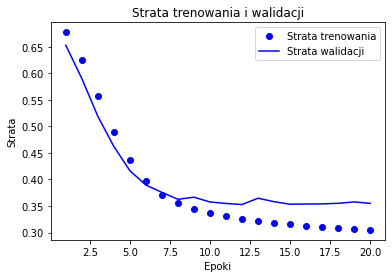

In [80]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')

plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

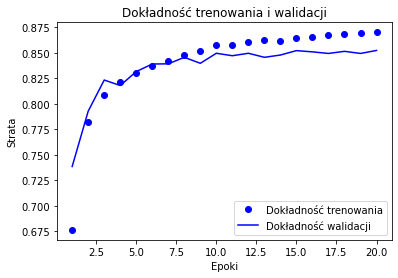

In [81]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacji')

plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

In [83]:
test_data = pd.read_csv('../Data/test.csv')

nan_idx = test_data[pd.isnull(test_data.text)].index.tolist()
test_data.loc[nan_idx, 'text'] = ' '

x_test = tfidf_vectorizer.transform(test_data.text)[:, :MAX_FEATURE_LEN]
y_test = test_data.label

model.evaluate(x_test, y_test)

5200/5200 [==============================] - 1s 185us/step


[1.0465981976802532, 0.6373077034950256]